In [35]:
from sklearn import preprocessing
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree



In [4]:
import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as mp
from sentence_transformers import SentenceTransformer
model=SentenceTransformer('sentence-transformers/sentence-t5-base')
a = 'training.xlsx'
dtrain = pd.read_excel(a)
y = 'testing.xlsx'
dtest = pd.read_excel(y)

    #class labelling
dtrain['class'] = dtrain['output'].apply(lambda x: 'Correct' if x == 5 else ('Partially correct' if x>=2 and x<5 else 'Incorrect'))
correct = dtrain[dtrain['class'] == 'Correct']
partial = dtrain[dtrain['class'] == 'Partially correct']
incorrect = dtrain[dtrain['class'] == 'Incorrect']

dtrain.to_excel('training_labelled.xlsx', index=False)

    #removing line breaks and converting to str
def remove(s):
    if isinstance(s, str):
        return ' '.join(s.splitlines())
    else:
        return s
    
dtrain['string_converted_input'] = dtrain['input'].apply(remove)
dtrain['EmbeddingsLM']=dtrain['string_converted_input'].apply(lambda x:model.encode(str(x)))

dtest['string_converted_equation'] = dtest['Equation'].apply(remove)
dtest['EmbeddingsLM']=dtest['string_converted_equation'].apply(lambda x:model.encode(str(x)))

In [5]:
    #stripping spaces in embeddings
dtrain['Embeddings_converted'] = dtrain['EmbeddingsLM'].apply(lambda x: x.tolist())
num_columns = len(dtrain['Embeddings_converted'][0]) 

In [6]:
for i in range(num_columns):
    col_name = "Embedding_"+str(i)
    dtrain[col_name] = dtrain['Embeddings_converted'].apply(lambda x: x[i])

dtrain.to_excel('training_data_updated.xlsx', index=False)

C:\Users\subhi\AppData\Local\Temp\ipykernel_35432\1921526927.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dtrain[col_name] = dtrain['Embeddings_converted'].apply(lambda x: x[i])
C:\Users\subhi\AppData\Local\Temp\ipykernel_35432\1921526927.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dtrain[col_name] = dtrain['Embeddings_converted'].apply(lambda x: x[i])
C:\Users\subhi\AppData\Local\Temp\ipykernel_35432\1921526927.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

In [7]:
#taking out numeric values to calculate mean etc
numeric_dtrain=dtrain.copy()
numeric_dtrain.drop(columns=['input','string_converted_input'], inplace=True)

def labelenc(x):
    if(x=='Incorrect'):
        return 0
    elif(x=='Partially correct'):
        return 1
    if(x=='Correct'):
        return 2

numeric_dtrain['class_encoded'] = dtrain['class'].apply(labelenc)
numeric_dtrain.drop(columns=['class','EmbeddingsLM','Embeddings_converted'], inplace=True)

columns = numeric_dtrain.columns.tolist()
first_col = columns.pop(0)
columns.insert(-1, first_col)
numeric_dtrain = numeric_dtrain[columns]

numeric_dtrain.to_excel('numeric_data_updated.xlsx', index=False)

In [8]:
'''
A1. Evaluate the intra-class spread and interclass distances between the classes in your dataset. 
If your data deals with multiple classes, you can take any two classes. 

'''
class_0  = numeric_dtrain[numeric_dtrain['class_encoded'] == 0]
class_1  = numeric_dtrain[numeric_dtrain['class_encoded'] == 1]
class_2  = numeric_dtrain[numeric_dtrain['class_encoded'] == 2]
#selecting Correct class and Incorrect class
avg_vector_0 = class_0.mean().values
avg_vector_2 = class_2.mean().values
std_vector_0 = (class_0.std().values).tolist()
std_vector_2 = (class_2.std().values).tolist()

distance = np.linalg.norm(avg_vector_0 - avg_vector_2)
print("\n Euclidean distance between the 2 class centroid is = ",distance,"\n")


 Euclidean distance between the 2 class centroid is =  4.427967599456386 



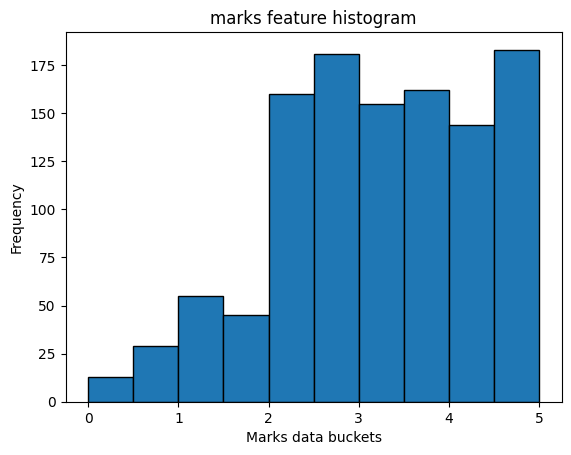

In [9]:
'''
A2. Take any feature from your dataset. 
Observe the density pattern for that feature by plotting the
histogram. Use buckets (data in ranges) for histogram generation and study. Calculate the mean and
variance from the available data.
(Suggestion: numpy.histogram()gives the histogram data. 
Plot of histogram may be achieved with matplotlib.pyplot.hist())
'''
feature = numeric_dtrain['output']
counts, bin_edges = np.histogram(feature, bins=10)
mp.hist(feature, bins=10, edgecolor='k')
mp.xlabel('Marks data buckets')
mp.ylabel('Frequency')
mp.title('marks feature histogram')
mp.show()
#Density pattern:
#it shows that most people scored between 2.5 to 3 and between 4.5 to 5
#there is narrow distribution between the buckets so the spread is less


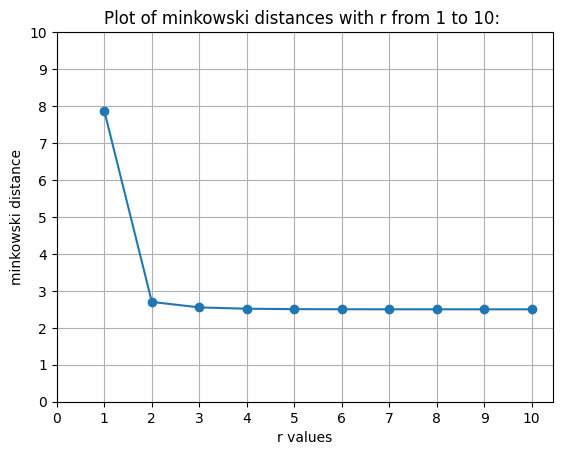

In [10]:
'''
A3. Take any two feature vectors from your dataset. 
Calculate the Minkowski distance with r from 1 to 10. 
Make a plot of the distance and observe the nature of this graph.

'''
#choosing 360th and 1120th vectors.
feature_vector_1 = numeric_dtrain.iloc[359].values
feature_vector_2 = numeric_dtrain.iloc[1119].values

r = [1,2,3,4,5,6,7,8,9,10]
mink_dists = []
for i in range(1,11):
    d = np.linalg.norm(feature_vector_1 - feature_vector_2, ord=i)
    mink_dists.append(d)

mp.plot(r, mink_dists,marker='o')
mp.xticks([0,1,2,3,4,5,6,7,8,9,10])
mp.yticks([0,1,2,3,4,5,6,7,8,9,10])
mp.xlabel('r values')
mp.ylabel('minkowski distance')
mp.title('Plot of minkowski distances with r from 1 to 10: ')
mp.grid(True)
mp.show()

In [44]:
'''
A4. Divide dataset in your project into two parts - train & test set. 
To accomplish this, use the train_test_split() function available in SciKit. 
See below sample code for help:
>>> import numpy as np
>>> from sklearn.model_selection import train_test_split
>>> X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)
X is the feature vector set for your project and y is the class levels for vectors present in X.
Note: Before set split, make sure you have only two classes. 
If your project deals with multi-class problem, take any two classes from them.
'''
#choosing 2 classes. class 0-incorrect and class 2-correct
class1_removed_set = numeric_dtrain[numeric_dtrain['class_encoded'].isin([0 , 2])]
X = class1_removed_set.iloc[0:, 0:-1]
Y = class1_removed_set['class_encoded']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
Y_test = pd.DataFrame(Y_test)
# class1_removed_set.to_excel('random.xlsx', index=False)
# X_test.to_excel('random_X_test.xlsx', index=False)
# Y_test.to_excel('random_Y_test.xlsx', index=False)


Training Set Accuracy: 1.0
Testing Set Accuracy: 1.0
Tree Depth: 1
Predicted class=  2


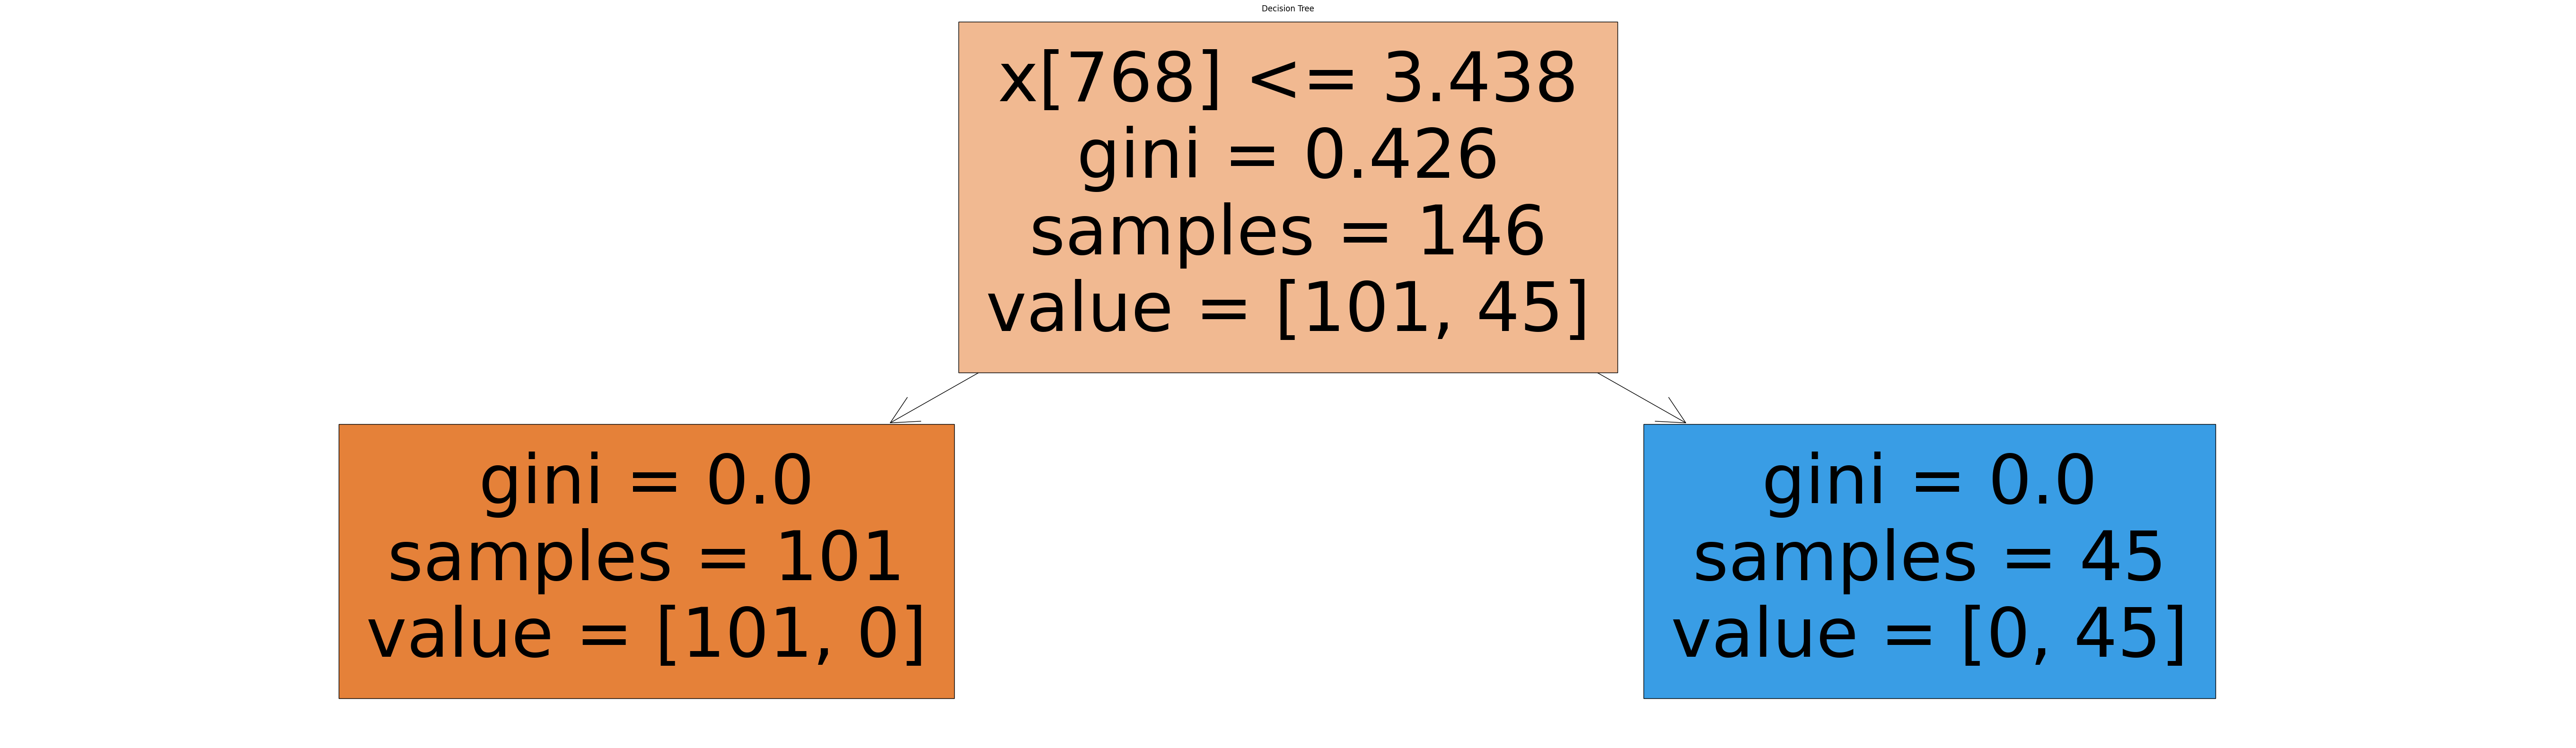

In [45]:
#lab4 part using project dataset:
''' 
A4. Create a Decision Tree classifier on your project data. Study the accuracy for training and test
data and infer the accuracy of tree construction. Plot the Decision Tree obtained above.

'''
model_fortree = DecisionTreeClassifier()
model_fortree.fit(X_train, Y_train)
training_accuracy = model_fortree.score(X_train, Y_train)
testing_accuracy = model_fortree.score(X_test, Y_test)
print("Training Set Accuracy:", training_accuracy)
print("Testing Set Accuracy:", testing_accuracy)
tree_depth = model_fortree.get_depth()
print("Tree Depth:", tree_depth)
# print(X_test.iloc[10])
prediction_ = model_fortree.predict([X_test.iloc[10]])
print("Predicted class= ",prediction_[0])
mp.figure(figsize=(70, 20))
plot_tree(model_fortree, filled=True)
mp.title("Decision Tree")
mp.show()


Training Set Accuracy: 1.0
Testing Set Accuracy: 1.0
Tree Depth: 1
Predicted class=  2


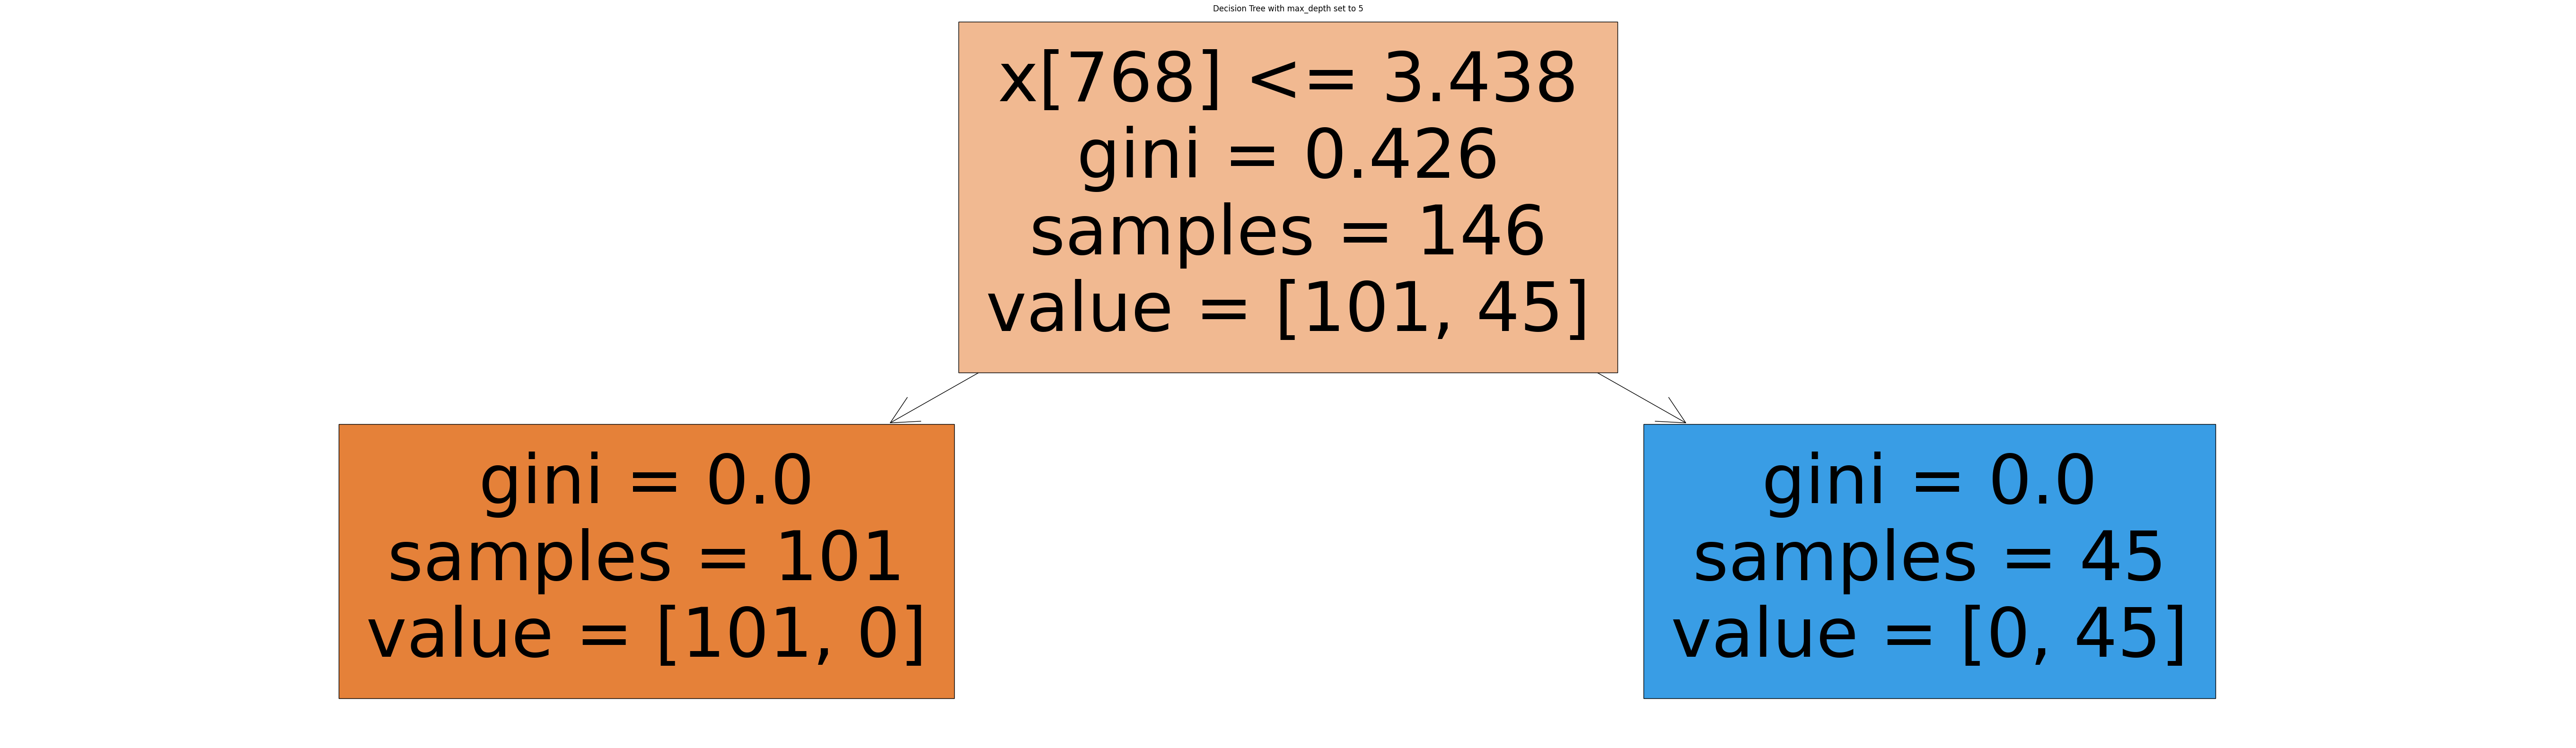

In [46]:
''' 
A5. Impose a max_depth constraint on the tree construction. Construct the tree again and check the
accuracies. Visualize the tree constructed with max_depth constraint.
'''
model_constrained = DecisionTreeClassifier(max_depth=5)
model_constrained.fit(X_train, Y_train)
training_accuracy = model_constrained.score(X_train, Y_train)
testing_accuracy = model_constrained.score(X_test, Y_test)
print("Training Set Accuracy:", training_accuracy)
print("Testing Set Accuracy:", testing_accuracy)
tree_depth = model_constrained.get_depth()
print("Tree Depth:", tree_depth)
# print(X_test.iloc[10])
prediction_ = model_constrained.predict([X_test.iloc[10]])
print("Predicted class= ",prediction_[0])
mp.figure(figsize=(70, 20))
plot_tree(model_constrained, filled=True)
mp.title("Decision Tree with max_depth set to 5")
mp.show()

Training Set Accuracy: 1.0
Testing Set Accuracy: 1.0
Tree Depth: 1
Predicted class=  2


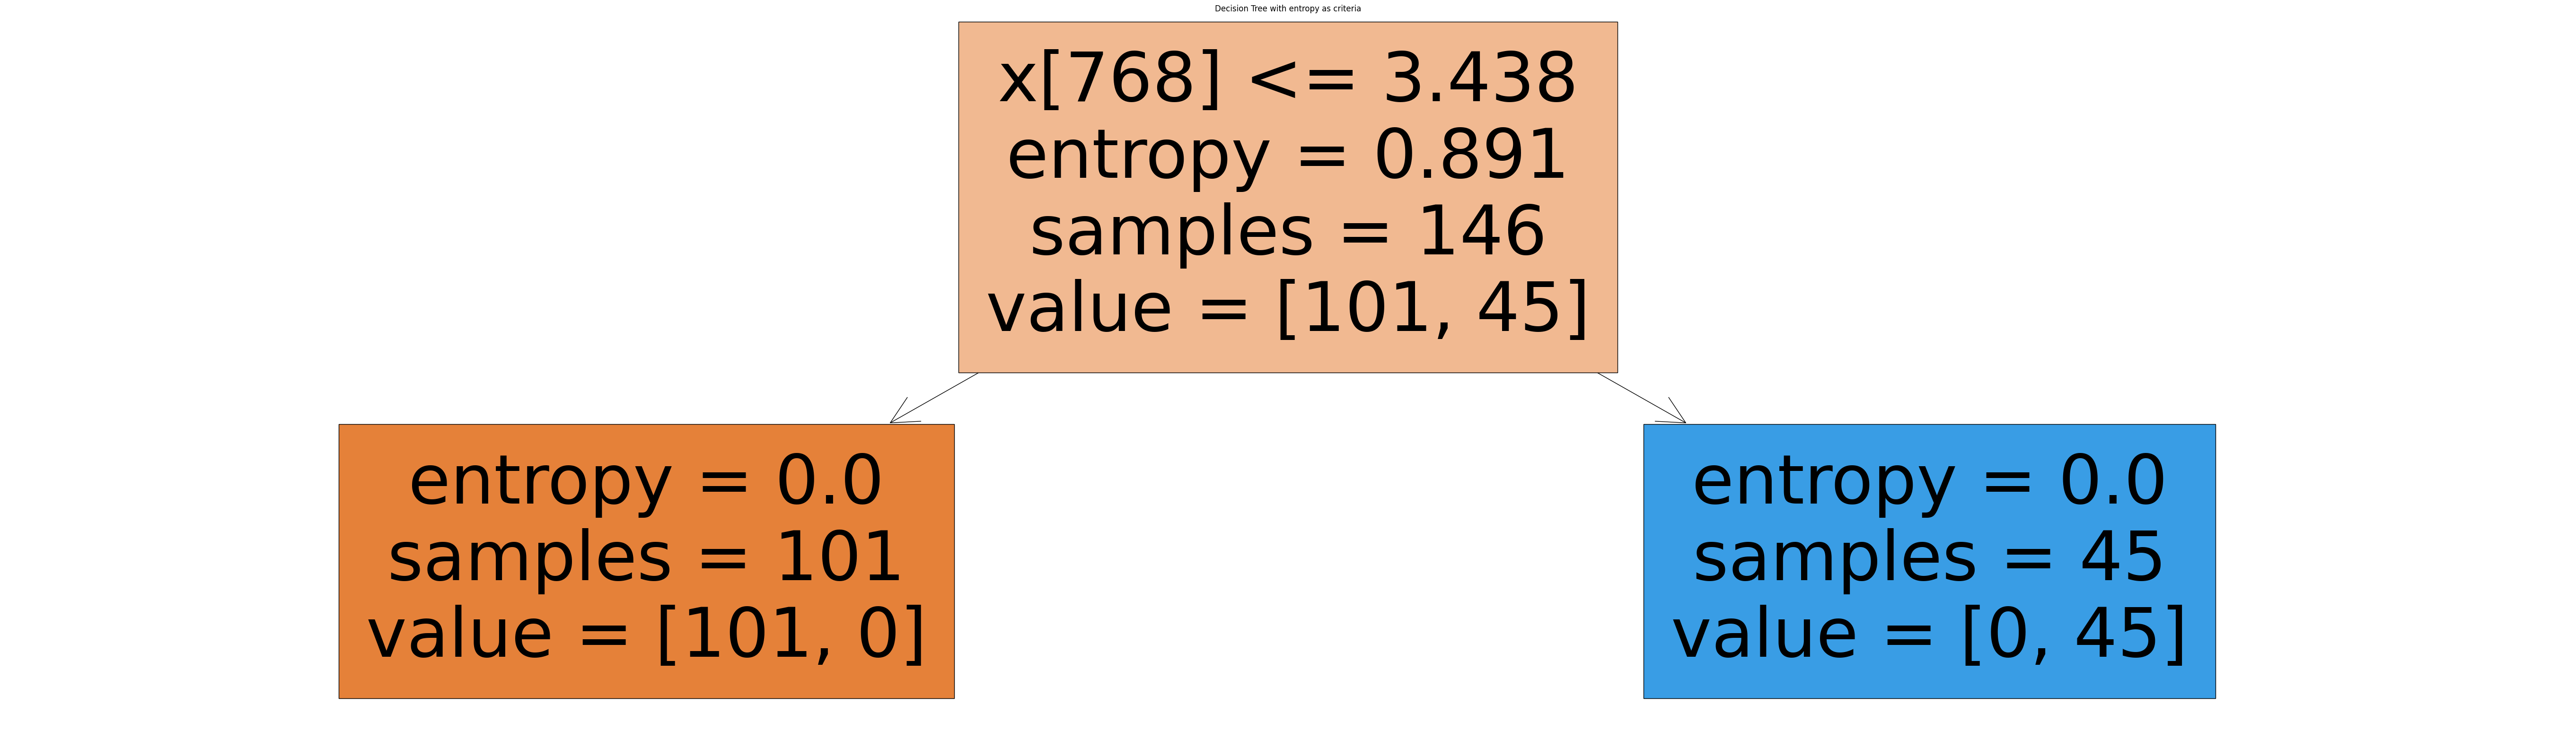

In [47]:
''' 
A6. Study the criterion of the DT in the above model. Change the criterion to “Entropy” and study
the model & graph. Find the differences between the default criterion and entropy criterion.
'''

#criteria in previous model was Gini Index as default criterion
model_entropy = DecisionTreeClassifier(criterion="entropy")
model_entropy.fit(X_train, Y_train)
training_accuracy = model_entropy.score(X_train, Y_train)
testing_accuracy = model_entropy.score(X_test, Y_test)
print("Training Set Accuracy:", training_accuracy)
print("Testing Set Accuracy:", testing_accuracy)
tree_depth = model_entropy.get_depth()
print("Tree Depth:", tree_depth)
# print(X_test.iloc[10])
prediction_ = model_entropy.predict([X_test.iloc[10]])
print("Predicted class= ",prediction_[0])
mp.figure(figsize=(70, 20))
plot_tree(model_entropy, filled=True)
mp.title("Decision Tree with entropy as criteria")
mp.show()

#in prev DT max IG attribute was taken as root node
#in this DT least entropy attribute is taken as root node
#both cases x[768] (output) attribute is selected as root node.